In [2]:
%%capture
%pip install tensorflow

In [3]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

2024-11-17 21:07:08.885740: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 21:07:08.887182: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 21:07:08.890530: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 21:07:08.899261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731877628.913747   13944 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731877628.91

In [4]:
input_file = "img.png"

In [5]:
# 1. Загрузка изображения и преобразование в тензор
def load_image(file_path):
    image = Image.open(file_path).convert("RGB")  # Открытие и преобразование в RGB
    image_tensor = tf.convert_to_tensor(np.array(image), dtype=tf.float32)  # Преобразование в тензор
    image_tensor = tf.expand_dims(image_tensor, axis=0)  # Добавление размерности батча
    return image_tensor, image.size

In [6]:
image_tensor, size = load_image(input_file)

image_tensor

2024-11-17 21:07:11.938598: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


<tf.Tensor: shape=(1, 1323, 2134, 3), dtype=float32, numpy=
array([[[[62., 64., 73.],
         [59., 62., 71.],
         [35., 38., 48.],
         ...,
         [35., 38., 48.],
         [35., 38., 48.],
         [35., 38., 48.]],

        [[62., 64., 73.],
         [54., 57., 66.],
         [35., 38., 48.],
         ...,
         [35., 38., 48.],
         [35., 38., 48.],
         [35., 38., 48.]],

        [[62., 64., 73.],
         [50., 52., 62.],
         [35., 38., 48.],
         ...,
         [35., 38., 48.],
         [35., 38., 48.],
         [35., 38., 48.]],

        ...,

        [[13., 17., 22.],
         [13., 17., 22.],
         [13., 17., 22.],
         ...,
         [13., 17., 22.],
         [13., 17., 22.],
         [13., 17., 22.]],

        [[13., 17., 22.],
         [13., 17., 22.],
         [13., 17., 22.],
         ...,
         [13., 17., 22.],
         [13., 17., 22.],
         [13., 17., 22.]],

        [[13., 17., 22.],
         [13., 17., 22.],
         [13.,

```

`shape=(1, 1323, 2134, 3)` — форма (размеры) тензора:

1 — это размер батча. В данном случае у нас только одно изображение, поэтому размер батча равен 1.

    1323 — высота изображения в пикселях.

    2134 — ширина изображения в пикселях.

3 — количество каналов изображения (Red, Green, Blue, то есть RGB).

`dtype=float32` — тип данных элементов тензора. Здесь элементы тензора представлены числами с плавающей точкой (32-битная точность). Такие типы данных удобны для математических операций, включая свёртки.

In [7]:
# 2. Определение ядра свёртки
kernel = tf.constant([[-1, 0, 1], 
                      [-1, 0, 1], 
                      [-1, 0, 1]], 
                      dtype=tf.float32, 
                      shape=(3, 3, 1, 1))
kernel

<tf.Tensor: shape=(3, 3, 1, 1), dtype=float32, numpy=
array([[[[-1.]],

        [[ 0.]],

        [[ 1.]]],


       [[[-1.]],

        [[ 0.]],

        [[ 1.]]],


       [[[-1.]],

        [[ 0.]],

        [[ 1.]]]], dtype=float32)>

Форма тензора ядра свёртки shape=(3, 3, 1, 1) описывает его размеры по четырём измерениям. Давайте разберём каждый из них:

3 (высота) — количество строк в ядре свёртки. Это соответствует высоте фильтра, который будет применяться к изображению. Здесь ядро имеет размер 3 пикселя по вертикали.

3 (ширина) — количество столбцов в ядре свёртки. Это ширина фильтра, которая тоже составляет 3 пикселя.

1 (глубина входного изображения) — число каналов входных данных, к которым применяется фильтр. Поскольку указано 1, это значит, что ядро рассчитано на обработку только одного канала (например, для обработки одного цветового компонента изображения — R, G или B). Если входное изображение многоканальное (RGB), для каждого канала свёртка выполняется отдельно.

1 (число фильтров) — количество различных фильтров, которые ядро содержит. В данном случае у нас один фильтр. Если бы это значение было больше, выход после свёртки содержал бы результаты для всех фильтров (многоканальный выход).

Итог:
Тензор ядра свёртки с формой (3, 3, 1, 1) представляет фильтр размером 
3
×
3
3×3, который:

Обрабатывает один канал входных данных.
Возвращает один канал в результате (один выходной фильтр).
Такой формат используется в TensorFlow для унификации обработки свёрточных операций, позволяя легко масштабировать их для многоканальных данных или создания нескольких фильтров.

In [8]:
# 3. Применение свёртки
def apply_convolution(image_tensor, kernel):
    # Разделение по каналам для независимой обработки
    channels = tf.split(image_tensor, num_or_size_splits=3, axis=-1)
    convolved_channels = []
    for channel in channels:
        convolved = tf.nn.conv2d(channel, filters=kernel, strides=[1, 1, 1, 1], padding='SAME')
        convolved_channels.append(convolved)
    # Объединение каналов обратно
    convolved_image = tf.concat(convolved_channels, axis=-1)
    return convolved_image[0]  # Убираем размерность батча

In [9]:
convolved_image = apply_convolution(image_tensor, kernel)

convolved_image

<tf.Tensor: shape=(1323, 2134, 3), dtype=float32, numpy=
array([[[ 113.,  119.,  137.],
        [ -54.,  -52.,  -50.],
        [ -43.,  -43.,  -41.],
        ...,
        [   0.,    0.,    0.],
        [   0.,    0.,    0.],
        [ -70.,  -76.,  -96.]],

       [[ 163.,  171.,  199.],
        [ -81.,  -78.,  -75.],
        [ -58.,  -57.,  -55.],
        ...,
        [   0.,    0.,    0.],
        [   0.,    0.,    0.],
        [-105., -114., -144.]],

       [[ 148.,  156.,  185.],
        [ -81.,  -78.,  -75.],
        [ -43.,  -42.,  -41.],
        ...,
        [   0.,    0.,    0.],
        [   0.,    0.,    0.],
        [-105., -114., -144.]],

       ...,

       [[  39.,   51.,   66.],
        [   0.,    0.,    0.],
        [   0.,    0.,    0.],
        ...,
        [   0.,    0.,    0.],
        [   0.,    0.,    0.],
        [ -39.,  -51.,  -66.]],

       [[  39.,   51.,   66.],
        [   0.,    0.,    0.],
        [   0.,    0.,    0.],
        ...,
        [   0.,    0

In [10]:
# 4. Сохранение результата
def save_image(tensor, size, file_path):
    tensor = tf.clip_by_value(tensor, 0, 255)  # Обрезка значений в диапазон [0, 255]
    image_array = tensor.numpy().astype(np.uint8)  # Преобразование в uint8
    image = Image.fromarray(image_array)
    image.save(file_path)

In [11]:
# 4. Сохранение результата с нормированием
def save_image_normalized(tensor, file_path):
    # Преобразование тензора в numpy-массив для обработки
    tensor = tensor.numpy()
    min_val = np.min(tensor)  # Минимальное значение
    max_val = np.max(tensor)  # Максимальное значение
    
    # Нормирование в диапазон [0, 255]
    if max_val > min_val:  # Чтобы избежать деления на 0
        tensor = (tensor - min_val) / (max_val - min_val) * 255
    else:
        tensor = np.zeros_like(tensor)  # Если min == max, делаем однородное изображение
    
    # Преобразование в uint8
    tensor = tensor.astype(np.uint8)
    
    # Сохранение как изображения
    image = Image.fromarray(tensor)
    image.save(file_path)


In [12]:
output_file = "img-result.jpg"
output_norm_file = "img-result-norm.jpg"

In [13]:
save_image(convolved_image, size, output_file)
save_image_normalized(convolved_image, output_norm_file)

In [14]:
input_image = Image.open(input_file)
output_image = Image.open(output_file)
output_normed_image = Image.open(output_norm_file)

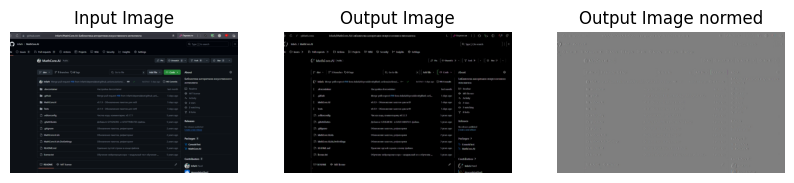

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(input_image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Output Image")
plt.imshow(output_image)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Output Image normed")
plt.imshow(output_normed_image)
plt.axis("off")

plt.show()

In [17]:
# подвыборка

subsampled_img = convolved_image[::2, ::2]

subsampled_img

<tf.Tensor: shape=(662, 1067, 3), dtype=float32, numpy=
array([[[113., 119., 137.],
        [-43., -43., -41.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[148., 156., 185.],
        [-43., -42., -41.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[115., 124., 154.],
        [-10., -10., -10.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       ...,

       [[ 39.,  51.,  66.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[ 39.,  51.,  66.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[ 26.,  